In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       271
           1       0.98      0.96      0.97       422

    accuracy                           0.97       693
   macro avg       0.96      0.97      0.96       693
weighted avg       0.97      0.97      0.97       693



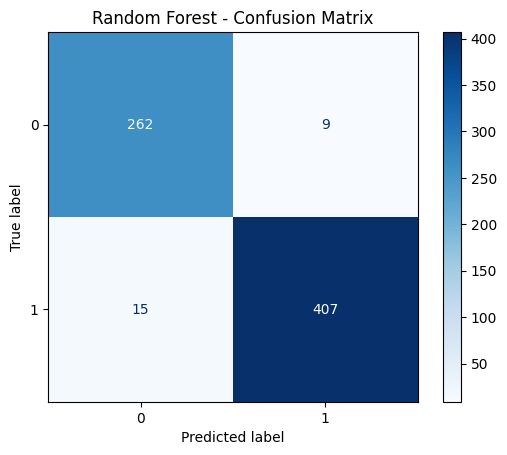

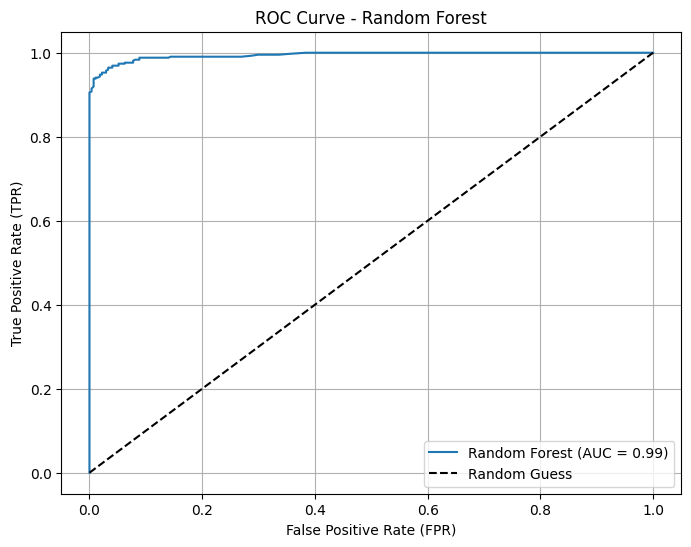

Random Forest - Mean Accuracy: 0.9478 (+/- 0.0213)

Cross-Validation Summary:
   Accuracy    Fold
0  0.914863  Fold 1
1  0.959596  Fold 2
2  0.962482  Fold 3
3  0.930736  Fold 4
4  0.971098  Fold 5


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load Data
normal_df = pd.read_csv('/content/drive/MyDrive/FYP/extracted_features_angle_wise_Normal.csv')
covid_df = pd.read_csv('/content/drive/MyDrive/FYP/extracted_features_angle_wise_Covid.csv')

# Assign labels and combine datasets
normal_df['Target'] = 0
covid_df['Target'] = 1
df = pd.concat([normal_df, covid_df], ignore_index=True)

radiomic_features = [
    'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy',
    'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis',
    'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
    'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range',
    'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness',
    'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance',
    'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade',
    'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage',
    'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm',
    'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance',
    'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_JointEntropy', 'original_glcm_MCC',
    'original_glcm_MaximumProbability', 'original_glcm_SumAverage', 'original_glcm_SumEntropy', 'original_glcm_SumSquares',
    'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceNonUniformityNormalized',
    'original_gldm_DependenceVariance', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_GrayLevelVariance',
    'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis',
    'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_gldm_SmallDependenceEmphasis',
    'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGrayLevelEmphasis',
    'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformityNormalized', 'original_glrlm_GrayLevelVariance',
    'original_glrlm_HighGrayLevelRunEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis',
    'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_RunEntropy',
    'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_RunPercentage',
    'original_glrlm_RunVariance', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunHighGrayLevelEmphasis',
    'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized',
    'original_glszm_GrayLevelVariance', 'original_glszm_HighGrayLevelZoneEmphasis', 'original_glszm_LargeAreaEmphasis',
    'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis',
    'original_glszm_SizeZoneNonUniformity', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_glszm_SmallAreaEmphasis',
    'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy',
    'original_glszm_ZonePercentage', 'original_glszm_ZoneVariance', 'original_ngtdm_Busyness', 'original_ngtdm_Coarseness',
    'original_ngtdm_Complexity', 'original_ngtdm_Contrast', 'original_ngtdm_Strength'
]

# Check for missing features
missing_features = [col for col in radiomic_features if col not in df.columns]
if missing_features:
    raise ValueError(f"The following features are missing: {missing_features}")

# Select features and target
X = df[radiomic_features]
y = df['Target']

# Handle missing data
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)

# Scale data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=20)
rf_clf.fit(X_train_balanced, y_train_balanced)

# Evaluate Random Forest Classifier
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest - Confusion Matrix")
plt.show()

# ROC Curve
y_pred_prob = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Cross-Validation
scores = cross_val_score(rf_clf, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)  # 5-fold CV
print(f"Random Forest - Mean Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Cross-Validation Summary
cv_summary = pd.DataFrame(scores, columns=['Accuracy'])
cv_summary['Fold'] = [f'Fold {i+1}' for i in range(5)]
print("\nCross-Validation Summary:")
print(cv_summary)


<ipython-input-17-c0a7c4eab88f>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='coolwarm')


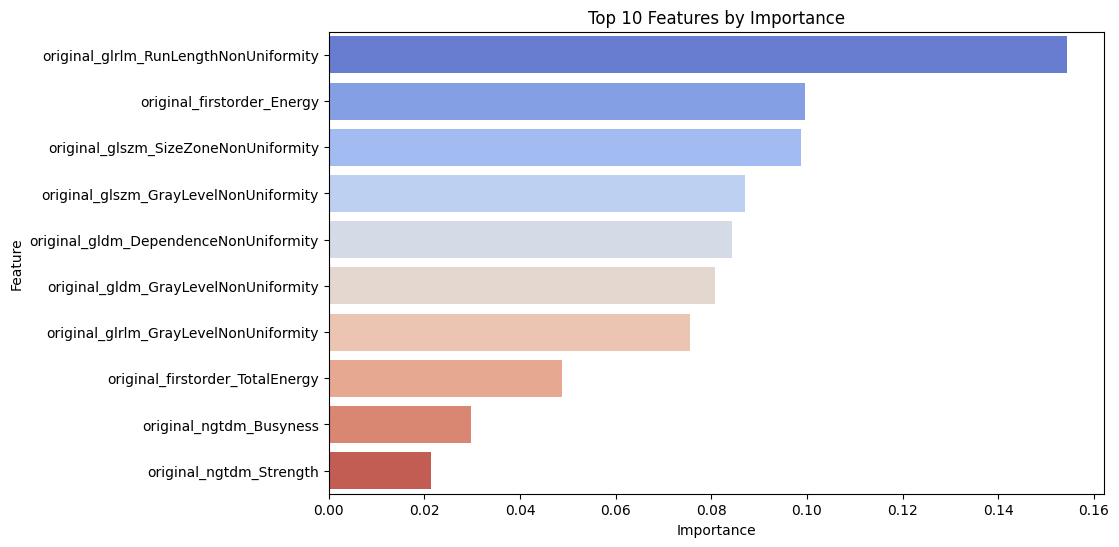

Top 10 Features for Classification:
                                  Feature  Importance
65  original_glrlm_RunLengthNonUniformity    0.154337
2              original_firstorder_Energy    0.099590
80   original_glszm_SizeZoneNonUniformity    0.098681
72  original_glszm_GrayLevelNonUniformity    0.087111
43  original_gldm_DependenceNonUniformity    0.084404
46   original_gldm_GrayLevelNonUniformity    0.080771
56  original_glrlm_GrayLevelNonUniformity    0.075624
15        original_firstorder_TotalEnergy    0.048698
88                original_ngtdm_Busyness    0.029824
92                original_ngtdm_Strength    0.021314


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data (ensure X_scaled and y are defined from preprocessing steps)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
best_rf_clf = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=20, class_weight='balanced')
best_rf_clf.fit(X_train, y_train)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importance from the trained Random Forest model
feature_importances = best_rf_clf.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': radiomic_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_10_features = importance_df.head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='coolwarm')
plt.title('Top 10 Features by Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Display the top 10 features
print("Top 10 Features for Classification:")
print(top_10_features)

